In [1]:
import mne
from mne.preprocessing import ICA
# raw_bv = mne.io.read_raw_brainvision('rest\INP0064_v1.4_rs11_S008_R003_04.12.23.vhdr')
raw_bv = mne.io.read_raw_brainvision('rest1_94/INP0094_v1.4_REST1_Op008_A002_S002_18.12.23.vhdr')
raw_bv.load_data()

Extracting parameters from rest1_94/INP0094_v1.4_REST1_Op008_A002_S002_18.12.23.vhdr...
Setting channel info structure...
Reading 0 ... 748677  =      0.000 ...   365.565 secs...


Measurement date,"December 18, 2023 13:28:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,65 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [2]:
# print(mne.get_config())

In [3]:
# print(raw_bv.info)
# print(raw_bv.ch_names)

In [4]:
# raw_bv.describe()

In [5]:
raw_bv_dropped = raw_bv.copy()

raw_bv_dropped.drop_channels(["EOG", "BIP1", "M1", "M2", "PO5", "PO6"])
# raw_bv_dropped.drop_channels(["BIP1"])

# raw_bv_dropped.rename_channels()

Measurement date,"December 18, 2023 13:28:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,59 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [6]:
# %matplotlib qt

# raw_bv_dropped.plot()

In [7]:
# raw_bv.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
# raw_bv.plot(duration=5, n_channels=30)
raw_bd_filtered = raw_bv_dropped.copy()
raw_bd_filtered = raw_bd_filtered.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


In [8]:
%matplotlib qt
# fig = raw.plot(start=2, duration=6)

In [9]:
# raw_bv.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)

In [10]:
biosemi64 = mne.channels.make_standard_montage("biosemi64")
# customMontage  = mne.channels.read_custom_montage("rest1_94\\reworkedElc.elc")

In [11]:
# biosemi64.plot()  #

# fig = biosemi64.plot(kind="3d", show=False)  # 3D
# fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial
# customMontage.plot()

In [12]:
raw_bd_filtered.set_montage(biosemi64)

Measurement date,"December 18, 2023 13:28:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,62 points
Good channels,59 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [13]:
raw_bdf_reref_obj = mne.set_eeg_reference(raw_bd_filtered)
raw_bdf_reref = raw_bdf_reref_obj[0]
# raw_bdf_reref.plot(title="reref")
# raw_bv_dropped.plot(title="original")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [14]:
ica = ICA(n_components=20, random_state=42, max_iter='auto')
ica.fit(raw_bdf_reref)


Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 29.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,51 iterations on raw data (748678 samples)
ICA components,20
Available PCA components,59
Channel types,eeg
ICA components marked for exclusion,—


In [15]:
# expl_var = ica.get_explained_variance_ratio(raw_reref)
# for channel_type, ratio in expl_var.items():
#     print(
#         f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
#     )

In [16]:
# ica.plot_sources(raw_reref, start=2)
# raw_reref.plot(start=0, duration=20)

In [17]:
#ica.plot_components()

In [18]:
# ica.plot_properties(raw_reref, picks=range(0, 9))

In [19]:
# ica.exclude = [0, 1, 7, 14, 16, 17] # 30 components
# ica.exclude = [0, 3, 5, 14, 13, 56] 
ica.exclude = [0, 1, 4, 7, 11, 13, 15, 19]
raw_bdfr_reconst = raw_bdf_reref.copy()
ica.apply(raw_bdfr_reconst)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 59 PCA components


Measurement date,"December 18, 2023 13:28:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,62 points
Good channels,59 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [20]:
# raw_bdfr_reconst.plot(title="ica")
# raw_bv_dropped.plot(title="original")
# raw2 = raw_bv.copy()
# raw2.filter(l_freq=1, h_freq=30)
# raw2.plot(title="1-30")

In [21]:
# %matplotlib inline
raw_bv_reconst_reref = raw_bdfr_reconst.copy()
raw_bv_reconst_reref.set_montage(biosemi64)
# for i in range(0, 50):
#     tmin=(0.1*i)
#     tmax=(1+(0.1*i))
#     print(f'tmin = {tmin}; tmax = {tmax}')
#     spectrum = raw_bv_reconst_reref.compute_psd(fmin=1, fmax=40, tmin=tmin, tmax=tmax)
#     spectrum.plot_topomap(bands={'Theta (4-8 Hz)': (4, 8)})
#     spectrum.plot_topomap(bands={'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
#          'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
#          'Gamma (30-45 Hz)': (30, 45)})
    # spectrum.plot()

    #построить поочередные картинки


Measurement date,"December 18, 2023 13:28:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,62 points
Good channels,59 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [22]:
def raw_compute_psd(raw, tmin, tmax):
    return raw.compute_psd(
        fmin=1,
        fmax=40,
        tmin=tmin,
        tmax=tmax,
        method='welch',
        n_fft=2048,
        window='hann',
        n_per_seg=2048,
        n_overlap = 0,
    )

In [23]:
import pandas as pd

def calc_one_second_spectrum(raw, time_start, time_end):
    spectrum = raw_compute_psd(
        raw=raw,
        tmin=time_start,
        tmax=time_start + 1
    )
    aggregate_df = spectrum.to_data_frame()
    aggregate_df["tmin"] = time_start
    aggregate_df["tmax"] = time_start + 1
    for i in range(time_start+1, (time_end*2)-1):
        tmin = i/2
        tmax = tmin+1
        print(f"tmin: {tmin} | tmax: {tmax}")
        spectrum = raw_compute_psd(
            raw=raw_bv_reconst_reref,
            tmin=tmin,
            tmax=tmax
        )
        df = spectrum.to_data_frame()
        df["tmin"] = tmin
        df["tmax"] = tmax
        aggregate_df = pd.concat([aggregate_df, df], ignore_index=True, axis=0)
    return aggregate_df


In [24]:
aggregate_df = calc_one_second_spectrum(
    raw = raw_bv_reconst_reref,
    time_start=0,
    time_end=30
)

Effective window size : 1.000 (s)
tmin: 0.5 | tmax: 1.5
Effective window size : 1.000 (s)
tmin: 1.0 | tmax: 2.0
Effective window size : 1.000 (s)
tmin: 1.5 | tmax: 2.5
Effective window size : 1.000 (s)
tmin: 2.0 | tmax: 3.0
Effective window size : 1.000 (s)
tmin: 2.5 | tmax: 3.5
Effective window size : 1.000 (s)
tmin: 3.0 | tmax: 4.0
Effective window size : 1.000 (s)
tmin: 3.5 | tmax: 4.5
Effective window size : 1.000 (s)
tmin: 4.0 | tmax: 5.0
Effective window size : 1.000 (s)
tmin: 4.5 | tmax: 5.5
Effective window size : 1.000 (s)
tmin: 5.0 | tmax: 6.0
Effective window size : 1.000 (s)
tmin: 5.5 | tmax: 6.5
Effective window size : 1.000 (s)
tmin: 6.0 | tmax: 7.0
Effective window size : 1.000 (s)
tmin: 6.5 | tmax: 7.5
Effective window size : 1.000 (s)
tmin: 7.0 | tmax: 8.0
Effective window size : 1.000 (s)
tmin: 7.5 | tmax: 8.5
Effective window size : 1.000 (s)
tmin: 8.0 | tmax: 9.0
Effective window size : 1.000 (s)
tmin: 8.5 | tmax: 9.5
Effective window size : 1.000 (s)
tmin: 9.0 | tm

In [25]:
# jupyter-pavel@192.168.88.244
# jira, nextcloud, confluence
# d 1-4
# t 4-8 4-6 6-8
# a 8-13 8-11 11-13
# b 13-30 13-20 20-25 25-30
# g 30-45
# TODO: проверить пересечения сегментов!!!
freq_dict = [
    ('delta', [1, 4]),

    ('theta-a', [4, 8]),
    ('theta-1', [4, 6]),
    ('theta-2', [6, 8]),

    ('alpha-a', [8, 13]),
    ('alpha-1', [8, 11]),
    ('alpha-2', [11, 13]),

    ('beta-a', [13, 30]),
    ('beta-1', [13, 20]),
    ('beta-2', [20, 25]),
    ('beta-3', [25, 30]),

    ('gamma', [30, 45])
]

# aggregate_df

In [26]:
def calc_mean_one_band(spectrum_df, freq_name, bandwidth_start, bandwidth_end, tmin):
    mean_df = spectrum_df \
        .loc[spectrum_df['freq'].isin(range(bandwidth_start, bandwidth_end + 1))] \
        .loc[spectrum_df['tmin'] == tmin] \
        .mean(axis=0)\
        .to_frame().T

    mean_df = mean_df.drop('freq', axis=1)

    mean_df['bandwidth_start'] = bandwidth_start
    mean_df['bandwidth_end'] = bandwidth_end
    mean_df['bandwidth_name'] = freq_name
    return mean_df

In [27]:
def calc_mean_for_bands(spectrum_df, freq_dict, time_start, time_end):
    mean_agr_df = pd.DataFrame()
    for freq_tup in freq_dict:
        freq_name = freq_tup[0]
        freqs = freq_tup[1]
        bandwidth_start = freqs[0]
        bandwidth_end = freqs[1]
        for i in range(time_start, (time_end*2)-1):
            tmin = i/2
            df = calc_mean_one_band(
                spectrum_df=spectrum_df,
                freq_name=freq_name,
                bandwidth_start=bandwidth_start,
                bandwidth_end=bandwidth_end,
                tmin=tmin
            )
            mean_agr_df = pd.concat([mean_agr_df, df], ignore_index=True, axis=0)
    return mean_agr_df

In [28]:
def calc_one_second_spectrum_and_freq_mean(raw, freq_dict, time_start, time_end):
    spectrum_df = calc_one_second_spectrum(
        raw=raw,
        time_start=time_start,
        time_end=time_end
    )
    return calc_mean_for_bands(
        spectrum_df=spectrum_df,
        freq_dict=freq_dict,
        time_start=time_start,
        time_end=time_end
    )

In [29]:
mean_agr_df = calc_one_second_spectrum_and_freq_mean(raw_bv_reconst_reref, freq_dict, 0, 60)

mean_agr_df.set_index(['tmin', 'bandwidth_name'])

Effective window size : 1.000 (s)
tmin: 0.5 | tmax: 1.5
Effective window size : 1.000 (s)
tmin: 1.0 | tmax: 2.0
Effective window size : 1.000 (s)
tmin: 1.5 | tmax: 2.5
Effective window size : 1.000 (s)
tmin: 2.0 | tmax: 3.0
Effective window size : 1.000 (s)
tmin: 2.5 | tmax: 3.5
Effective window size : 1.000 (s)
tmin: 3.0 | tmax: 4.0
Effective window size : 1.000 (s)
tmin: 3.5 | tmax: 4.5
Effective window size : 1.000 (s)
tmin: 4.0 | tmax: 5.0
Effective window size : 1.000 (s)
tmin: 4.5 | tmax: 5.5
Effective window size : 1.000 (s)
tmin: 5.0 | tmax: 6.0
Effective window size : 1.000 (s)
tmin: 5.5 | tmax: 6.5
Effective window size : 1.000 (s)
tmin: 6.0 | tmax: 7.0
Effective window size : 1.000 (s)
tmin: 6.5 | tmax: 7.5
Effective window size : 1.000 (s)
tmin: 7.0 | tmax: 8.0
Effective window size : 1.000 (s)
tmin: 7.5 | tmax: 8.5
Effective window size : 1.000 (s)
tmin: 8.0 | tmax: 9.0
Effective window size : 1.000 (s)
tmin: 8.5 | tmax: 9.5
Effective window size : 1.000 (s)
tmin: 9.0 | tm

,,Fp1,Fpz,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,FT7,FT8,TP7,TP8,PO7,PO8,Oz,tmax,bandwidth_start,bandwidth_end
tmin,bandwidth_name,,,,,,,,,,,,,,,,,,,,,
0.0,delta,3.089897e-11,1.900175e-11,3.786193e-11,7.383539e-11,1.414347e-11,2.789857e-12,1.825002e-12,5.339143e-11,3.888486e-11,2.454164e-12,...,7.591496e-11,2.599983e-11,1.775688e-11,3.699211e-11,1.849637e-11,2.983678e-11,2.810021e-11,1.0,1,4
0.5,delta,1.142581e-11,1.077699e-11,1.506567e-11,2.675057e-11,1.675734e-11,1.527969e-11,1.739188e-11,2.277312e-11,1.451099e-11,3.349479e-11,...,2.290497e-11,3.953595e-12,7.512597e-12,1.017416e-11,6.618256e-12,1.840754e-11,2.470134e-11,1.5,1,4
1.0,delta,4.601155e-12,9.388480e-12,5.984249e-12,1.317090e-11,2.118309e-11,4.860405e-12,1.734102e-12,6.701782e-12,2.303351e-11,6.332041e-12,...,1.634881e-11,4.656862e-12,1.714874e-11,1.565449e-11,2.881942e-12,7.346353e-12,2.716298e-11,2.0,1,4
1.5,delta,2.148157e-11,1.472119e-11,1.133861e-11,2.228664e-11,5.584870e-11,3.886737e-11,1.042502e-11,8.649197e-12,3.315121e-11,2.791214e-11,...,2.369157e-11,5.720467e-12,2.740508e-11,3.199312e-11,1.275060e-11,5.070248e-11,3.397840e-11,2.5,1,4
2.0,delta,4.867946e-12,5.838591e-12,4.616142e-12,6.358489e-12,1.494811e-11,2.332763e-11,7.423772e-12,2.405867e-11,2.360492e-12,3.475173e-11,...,6.693715e-12,5.758870e-12,5.922597e-12,2.505480e-11,1.535941e-11,3.458086e-11,2.108658e-11,3.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57.0,gamma,7.254147e-15,1.355597e-14,3.511886e-14,5.030306e-14,1.508339e-14,1.972922e-14,1.597821e-14,8.495338e-14,5.624390e-14,8.248173e-15,...,3.284110e-14,3.745196e-14,5.381974e-14,3.388007e-14,5.319918e-14,1.392843e-14,1.975834e-14,58.0,30,45
57.5,gamma,1.120245e-14,5.742020e-15,1.732127e-14,6.876366e-15,2.555723e-14,3.335790e-14,1.935824e-14,1.958890e-14,8.267487e-14,2.600692e-14,...,7.228462e-14,3.675428e-14,3.911433e-14,3.555083e-14,2.673400e-14,2.253416e-14,2.359497e-14,58.5,30,45
58.0,gamma,2.952732e-14,1.229156e-14,2.031872e-14,3.236515e-14,3.275294e-14,1.229038e-14,1.523677e-14,7.164165e-14,1.059621e-13,1.477944e-14,...,6.852652e-14,6.341958e-14,6.336601e-14,2.506944e-14,3.101638e-14,1.503172e-14,3.661935e-14,59.0,30,45


In [30]:
mne.events_from_annotations(raw_bv_reconst_reref)[1]

Used Annotations descriptions: ['Marker/Impedance', 'New Segment/', 'Stimulus/s11', 'Stimulus/s12', 'Stimulus/s2', 'Stimulus/s3', 'Stimulus/s4']


{'Marker/Impedance': 10001,
 'New Segment/': 99999,
 'Stimulus/s11': 10002,
 'Stimulus/s12': 10003,
 'Stimulus/s2': 10004,
 'Stimulus/s3': 10005,
 'Stimulus/s4': 10006}

In [31]:
mne.events_from_annotations(raw_bv_reconst_reref)[0]

Used Annotations descriptions: ['Marker/Impedance', 'New Segment/', 'Stimulus/s11', 'Stimulus/s12', 'Stimulus/s2', 'Stimulus/s3', 'Stimulus/s4']


array([[     0,      0,  99999],
       [ 87113,      0,  10006],
       [ 89197,      0,  10005],
       [ 93332,      0,  10002],
       [ 93332,      0,  10006],
       [154798,      0,  10005],
       [158931,      0,  10003],
       [158931,      0,  10006],
       [220399,      0,  10005],
       [224534,      0,  10002],
       [224534,      0,  10006],
       [285998,      0,  10005],
       [290133,      0,  10003],
       [290133,      0,  10006],
       [351597,      0,  10005],
       [355733,      0,  10002],
       [355733,      0,  10006],
       [417199,      0,  10005],
       [421299,      0,  10003],
       [421299,      0,  10006],
       [482765,      0,  10005],
       [486900,      0,  10002],
       [486900,      0,  10006],
       [548366,      0,  10005],
       [552499,      0,  10003],
       [552499,      0,  10006],
       [613966,      0,  10005],
       [618101,      0,  10002],
       [618101,      0,  10006],
       [679565,      0,  10005],
       [68

# Calculated EDF

In [32]:
edf = mne.io.read_raw_edf('./rest1_94/Test_01.EDF')

Extracting EDF parameters from /Users/anastet/Desktop/MNEBasePipeline/rest1_94/Test_01.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [33]:
spectrum_edf = edf.compute_psd(
    fmin=1, 
    fmax=40, 
    tmin=0, 
    tmax=11, 
    method='welch',
    n_fft=2048,
    window='hann',
    n_per_seg=2048,
    n_overlap = 1024,
)

Effective window size : 1.000 (s)


In [34]:
df = spectrum_edf.to_data_frame()
mean = df.mean(axis=0)
df2 = pd.concat([df.loc[:], mean.to_frame().T], ignore_index=True)
# df.append()
# df2
mean_frame = mean.to_frame().T
mean_frame_val = mean_frame.loc[:, mean_frame.columns!='freq']
mean_frame_val

# mean_frame_val.plot()

,Fp1,Fpz,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P6,PO3,PO4,FT7,FT8,TP7,TP8,PO7,PO8,Oz
0,1.013146e-11,3.168432e-12,9.963647e-12,4.218191e-12,3.194401e-12,2.800309e-12,5.245564e-12,5.117935e-12,2.949883e-12,2.864574e-12,...,3.289472e-12,2.747556e-12,4.112728e-12,4.946882e-12,7.748845e-12,2.864875e-12,3.444131e-12,5.774408e-12,4.173718e-12,5.225228e-12


In [35]:
df

,freq,Fp1,Fpz,Fp2,F7,F3,Fz,F4,F8,FC5,...,P6,PO3,PO4,FT7,FT8,TP7,TP8,PO7,PO8,Oz
0,1.0,7.421245e-11,2.781470e-11,5.726063e-11,4.414071e-11,2.657970e-11,2.895548e-11,4.465102e-11,4.887326e-11,2.161367e-11,...,3.626671e-11,2.419657e-11,4.661735e-11,3.625560e-11,6.168963e-11,2.215713e-11,4.347835e-11,5.626275e-11,4.698892e-11,8.186191e-11
1,2.0,5.478492e-11,2.482949e-11,3.901765e-11,2.698729e-11,2.129002e-11,2.358716e-11,3.294369e-11,2.851555e-11,1.759524e-11,...,2.333176e-11,1.809415e-11,2.521381e-11,2.732981e-11,3.261793e-11,2.082604e-11,3.021363e-11,4.650431e-11,2.549436e-11,3.653091e-11
2,3.0,3.715103e-11,1.881162e-11,2.644212e-11,1.232500e-11,1.288951e-11,1.673983e-11,2.391417e-11,1.795515e-11,9.512454e-12,...,1.289502e-11,1.394239e-11,1.860783e-11,1.501472e-11,1.906101e-11,1.111716e-11,1.023588e-11,3.501257e-11,1.920347e-11,2.045081e-11
3,4.0,2.770966e-11,1.702494e-11,2.012765e-11,9.057663e-12,1.091094e-11,1.304409e-11,2.399610e-11,2.428508e-11,1.095420e-11,...,1.761713e-11,2.155959e-11,2.631510e-11,1.327650e-11,2.408207e-11,1.228292e-11,1.529036e-11,3.532691e-11,2.669847e-11,2.432158e-11
4,5.0,1.707409e-11,9.644372e-12,1.174431e-11,7.562805e-12,8.540751e-12,1.100811e-11,1.863190e-11,1.311073e-11,8.461762e-12,...,1.478050e-11,1.093531e-11,1.732422e-11,1.170156e-11,1.174559e-11,1.177099e-11,1.079342e-11,1.479266e-11,1.745676e-11,1.376418e-11
5,6.0,1.064169e-11,4.003755e-12,8.578952e-12,3.539078e-12,3.282281e-12,3.978433e-12,9.380129e-12,4.897048e-12,3.556294e-12,...,5.297322e-12,3.946511e-12,6.469717e-12,6.249051e-12,5.581611e-12,6.651451e-12,4.928781e-12,7.862678e-12,6.627357e-12,6.493868e-12
6,7.0,7.642284e-12,3.937058e-12,7.518692e-12,5.017201e-12,3.426049e-12,2.073872e-12,6.691975e-12,4.782495e-12,3.935775e-12,...,3.244859e-12,2.794312e-12,3.016101e-12,6.164218e-12,4.813273e-12,4.423307e-12,2.732324e-12,5.329106e-12,2.983897e-12,3.193923e-12
7,8.0,5.183410e-12,2.177466e-12,4.079194e-12,3.996144e-12,2.869283e-12,1.802818e-12,4.674808e-12,2.954286e-12,3.718207e-12,...,3.755045e-12,2.971617e-12,4.407318e-12,5.761650e-12,3.014879e-12,4.280431e-12,2.959382e-12,5.787754e-12,4.475635e-12,4.217066e-12
8,9.0,4.046484e-12,1.333200e-12,3.488768e-12,1.977809e-12,2.242683e-12,1.886555e-12,3.662418e-12,2.151483e-12,2.076045e-12,...,3.206026e-12,2.373079e-12,3.762766e-12,3.039639e-12,2.830638e-12,3.648641e-12,3.315279e-12,5.019219e-12,3.883455e-12,4.444381e-12
9,10.0,3.716375e-12,1.198222e-12,3.132274e-12,1.575376e-12,1.823503e-12,1.673487e-12,3.134669e-12,1.441544e-12,1.587178e-12,...,1.482970e-12,1.704346e-12,1.994280e-12,2.079669e-12,2.134933e-12,1.730944e-12,2.363721e-12,2.858004e-12,2.002229e-12,3.145354e-12


/var/folders/tt/nr_wg20d5q13z6kxlpj2xsyc0000gn/T/ipykernel_8861/3039020215.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum_edf.plot(dB=False, amplitude=False)
/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/tt/nr_wg20d5q13z6kxlpj2xsyc0000gn/T/ipykernel_8861/3039020215.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum_edf.plot(dB=True, amplitude=False)
/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


<Axes: >

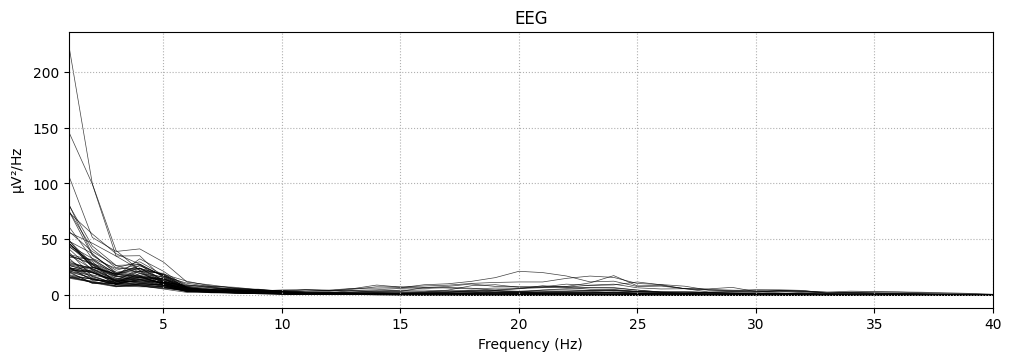

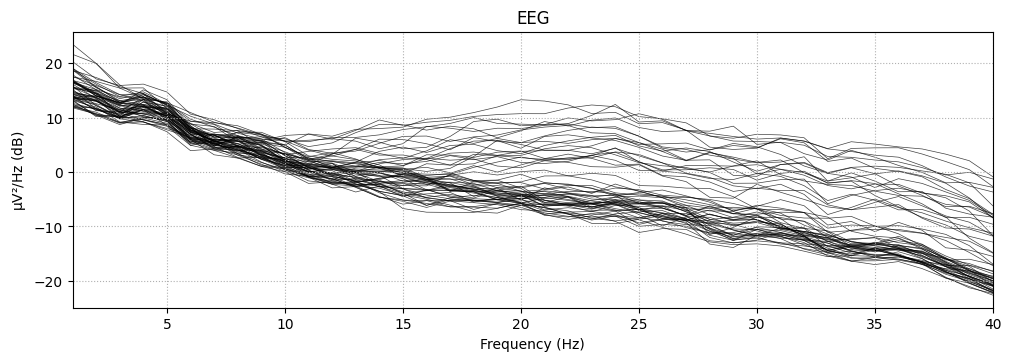

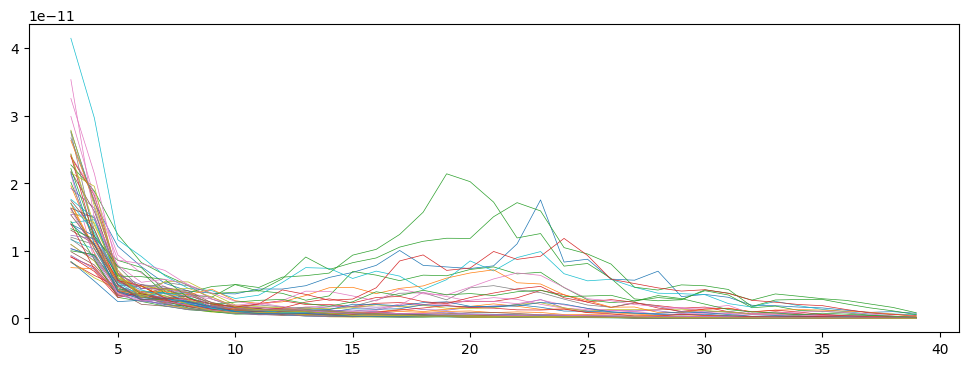

In [36]:
import math
import numpy as np

%matplotlib inline

#INFO: Проверка того как данные вообще хранятся

df_map = df.map(lambda x: (pow(10, x))-1)

# df_map = df.map(lambda x: np.float_power(np.float64(10), x))
df_val = df_map.loc[4:, df.columns!='freq']
# df_val.plot(legend=False, figsize=(12,4), linewidth=0.5)
spectrum_edf.plot(dB=False, amplitude=False)
spectrum_edf.plot(dB=True, amplitude=False)
# df_val2 = df.loc[:, df.columns!='freq']
# df_map2 = df.apply(lambda x: x.map(lambda y: (y if y >= 1 else math.sqrt(y * x['freq']))), axis=1)
# df_map3 = df_map2.apply(lambda x: x.map(lambda y: (y if y >= 1 else (y / x['freq']))), axis=1)
# df_val2 = df_map2.loc[3:, df.columns!='freq']
# df_val3 = df_map3.loc[1:, df.columns!='freq']


# df_val2.plot(legend=False, figsize=(12,4), linewidth=0.5)
df_val4 = df.loc[3:, df.columns!='freq']
df_val4.plot(legend=False, figsize=(12,4), linewidth=0.5)